In [1]:
from parcels import FieldSet, ParticleSet, AdvectionRK4_3D, AdvectionRK4, ParticleFile, JITParticle, ErrorCode, StateCode
import numpy as np
import xarray as xr
from glob import glob
from datetime import timedelta as delta
import matplotlib.pyplot as plt

In [2]:
member = 3

data_path = '/storage/shared/oceanparcels/input_data/NEMO_Ensemble/'
ufiles = sorted(glob(f"{data_path}NATL025-CJMCYC3.{member:03d}-S/1d/2010/NATL025*U.nc"))
vfiles = [f.replace('U.nc', 'V.nc') for f in ufiles]
wfiles = [f.replace('U.nc', 'W.nc') for f in ufiles]
mesh_mask = f"{data_path}GRID/coordinates_NATL025_v2.nc"
maskfile = f"{data_path}GRID/NATL025-CJMenobs01_byte_mask.nc"

filenames = {'U': {'lon': mesh_mask, 'lat': mesh_mask, 'depth': wfiles[0], 'data': ufiles},
             'V': {'lon': mesh_mask, 'lat': mesh_mask, 'depth': wfiles[0], 'data': vfiles},
             'W': {'lon': mesh_mask, 'lat': mesh_mask, 'depth': wfiles[0], 'data': wfiles},
             'mask': {'lon': mesh_mask, 'lat': mesh_mask, 'depth': wfiles[0], 'data': maskfile}}
variables = {'U': 'vozocrtx', 'V': 'vomecrty', 'W': 'vovecrtz', 'mask': 'fmask'}
dimensions = {'U': {'lon': 'glamf', 'lat': 'gphif', 'depth': 'depthw', 'time': 'time_counter'},
              'V': {'lon': 'glamf', 'lat': 'gphif', 'depth': 'depthw', 'time': 'time_counter'},
              'W': {'lon': 'glamf', 'lat': 'gphif', 'depth': 'depthw', 'time': 'time_counter'},
              'mask': {'lon': 'glamf', 'lat': 'gphif', 'depth': 'depthw'}}

fieldset = FieldSet.from_nemo(filenames, variables, dimensions, netcdf_decodewarning=False)

INFO: Compiled ArrayJITParticleRemoveLandPoints ==> /tmp/parcels-24236/lib9e06933c531e7ef8150e830a9a90f05e_0.so


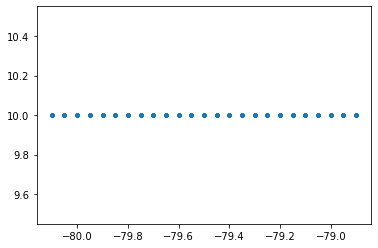

3000 0


In [16]:
dx, dz = 0.05, 20


X = np.arange(-81.5, -78.5, dx)
Y = 26.7*np.ones(X.shape)
Z = np.ones(X.shape)
pset = ParticleSet(fieldset, JITParticle, lon=X, lat=Y, depth=Z*dz/2)

# for z in np.arange(dz*1.5, 5000+dz/2, dz):
#     pset.add(ParticleSet(fieldset, JITParticle, lon=X, lat=Y, depth=z*Z))

def RemoveLandPoints(particle, fieldset, time):
    m = fieldset.mask[0, particle.depth, particle.lat, particle.lon]
    if math.fabs(m) < 0.9:
        particle.delete()

pset.execute(RemoveLandPoints, dt=0)

pset._collection._pclass.setLastID(0)

times = np.arange(np.datetime64('2010-01-02'), np.datetime64('2010-01-31'), np.timedelta64(6, 'h'))

lonp = [p.lon for p in pset]
latp = [p.lat for p in pset]
depp = [p.depth for p in pset]


pset = ParticleSet(fieldset, JITParticle, lon=lonp, lat=latp, depth=depp, time=times[0])
for t in times[1:]:
    pset.add(ParticleSet(fieldset, JITParticle, lon=lonp, lat=latp, depth=depp, time=t))


plt.plot(pset.lon, pset.depth, '.')
plt.show()
print(len(pset), pset[0].id)

58320


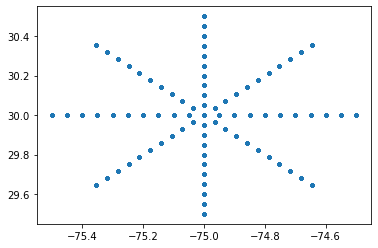

In [20]:
lonp = -75
latp = 30
depthp = 1

times = np.arange(np.datetime64('2000-01-01'), np.datetime64('2000-01-31'), np.timedelta64(1, 'h'))
pset = ParticleSet(fieldset, JITParticle, lon=lonp*np.ones(len(times)), lat=latp*np.ones(len(times)), 
                   depth=np.ones(len(times)), time=times)
len(pset)

for r in np.arange(0.05, 0.51, 0.05):
    for theta in np.arange(0, 2*np.pi, np.pi/4):
        pset.add(ParticleSet(fieldset, JITParticle, lon=lonp*np.ones(len(times))+np.sin(theta)*r, 
                             lat=latp*np.ones(len(times))+np.cos(theta)*r, 
                             depth=np.ones(len(times)), time=times))
print(len(pset))

plt.plot(pset.lon, pset.lat, '.')

In [ ]:
def SubmergeParticle(particle, fieldset, time):
        particle.depth = 0
        AdvectionRK4(particle, fieldset, time)  # perform a 2D advection because vertical flow will always push up in this case
        particle.time = time + particle.dt  # to not trigger kernels again, otherwise infinite loop
        particle.set_state(StateCode.Success)

In [ ]:
outfile = f"Pensemble_{member:03d}.zarr"
pfile = ParticleFile(outfile, pset, outputdt=delta(days=1))
pset.execute(AdvectionRK4_3D, dt=delta(hours=1), output_file=pfile, 
             recovery={ErrorCode.ErrorThroughSurface: SubmergeParticle})

In [ ]:
ds = xr.open_zarr('Pensemble_003.zarr/')

In [ ]:
pset._collection._pclass.lastID

In [ ]:
xr.open_dataset(mesh_mask)

In [ ]:
fieldset.W.depth[0]

P[0](lon=-49.000000, lat=0.000000, depth=1.000000, time=2635200.000000)